In [4]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import os
import seaborn as sb
import matplotlib
import scib

In this notebook, the level 1 annotation predictions from the integration 4_integrations_big.ipynb outputs are sub-clustered and annotated with level 2 cell types or adjusted level 1 annotations.

In [33]:
level1_marker = {
    'Bcell': ['CD79A', 'CD79B', 'MS4A1', 'IGKC', 'CD22', 'FCER2'],
    'Plasma cell': ['IGKC', 'IGHM', 'IGHA1', 'IGLC2', 'IGLC3', 'JCHAIN'],
    'Tcell': ['CD2', 'TRAC', 'CD69', 'CD3D', 'CD3E', 'CD4', 'CD8A', 'CD8B', 'EOMES', 'LAG3'],
    'NK': ['NKG7', 'XCL1', 'CTSW', 'XCL2', 'CD160', 'FCGR3A', 'PRF1', 'GNLY'],
    'DC': ['CLEC10A', 'FCER1A', 'CD1C', 'HLA-DRA', 'HLA-DRB1'],
    'EC': ['PECAM1', 'VWF', 'FABP4', 'CLDN5', 'IFI27', 'ECSCR', 'DYSF', 'CD34', 'COL4A1', 'COL4A2', 'SPARCL1', 'PLVAP', 'MPZL2', 'SULF1', 'EDN1'],
    'Fibroblast': ['LUM', 'DCN', 'COL1A1', 'COL1A2', 'FBLN1', 'THY1'],
    'Fibromyocyte': ['FN1', 'LUM', 'TNFRSF11B', 'ACTA2', 'C3', 'C7'],
    'SMC': ['ACTA2', 'MYH11', 'MYL9', 'TPM2', 'CALD1', 'TAGLN', 'TNFRSF11B', 'LUM', 'APOE', 'APOC1', 'AGT', 'NOTCH3', 'PDGFRB', 'MFAP4'],
    'Macrophage': ['C1QA', 'C1QB', 'C1QC', 'CD74', 'CXCL8', 'AIF1', 'CD14', 'CD68', 'ITGAM', 'CSF1R', 'HLA-DRA', 'LGALS3'],
    'Monocyte': ['FCN1', 'S100A8', 'S100A9', 'S100A12', 'VCAN', 'CD52', 'LYZ', 'CTSS'],
    'Mast': ['TPSAB1', 'TPSB2', 'KIT', 'HDC', 'CMA1'],
    'Neuron': ['PLP1'] #not used
}

In [144]:
resident_genes = ["LYVE1", "MRC1", "CD163", "FOLR2", "F13A1"] #CD206 is MRC1
foamy_genes = ["TREM2", "CD9", "GPNMB", "SPP1", "CTSL", "LIPA", "ACP5", "NPC2", "APOC1", "APOE", "PLIN2", "FABP5", "ABCA1", "ABCG1", "MMP9", "OLR1"]
inflammatory_genes = ["CD74", "CXCL2", "CCL3", "CCL4", "IL1B", "TNF", "CYBA", "LYZ", "S100A9", "S100A8", "AIF1", "JUNB", "NFKBIA", "MALAT1", "CASP1", "CASP4"]

cdc1 = ["CLEC9A", "IRF8", "SNX3"]
cdc2 = ["CD1C", "CLEC10A", "FCER1A"]
mature = ["CD40", "CD200", "TNFRSF4", "CD274", "LAMP3", "MARCKSL1", "IDO1"]


# T cells
#trying to get the markers from Slysz et al.
#CD3D exlcuded because active in all cells --> good because T cells marker
null = ["IL7R", "ANXA1", "FTH1", "CD4"]
one = ["CCL4L2", "CRTAM", "GZMK", "CCL4", "CD8A"]
two = ["GZMK", "CCL4", "CD8A", "GZMH"]
four = ["CXCL8", "IL1B", "LYZ", "HIST1HE1", "APOBEC3C"]
seven = ["TNFRSF4", "RTKN2", "BATF", "TNFRSF18", "TIGIT", "CD4", "FOXP3"]
plasma = ['IGKC', 'IGHM', 'IGHA1', 'IGLC2', 'IGLC3', 'JCHAIN']


intimal = ["RAMP2"]
proangiogenic = ["ACKR1", "AQP1", "FABP4"]
endomt = ["COL1A2", "FN1"]
lymphatic = ["LYVE1", "CCL21"]

macrophage_subtypes = {
    "Resident": resident_genes,
    "Foamy": foamy_genes,
    "Inflammatory": inflammatory_genes,
    "cDC1": cdc1,
    "cDC2": cdc2,
    "Mature": mature
}

dc_subtypes = {
    "cDC1": cdc1,
    "cDC2": cdc2,
    "Mature": mature,
    "Resident": resident_genes,
    "Foamy": foamy_genes,
    "Inflammatory": inflammatory_genes,
    "Monolvl1": level1_marker["Monocyte"]
}

tcells_subtypes = {
    "CD4+ TEff":null, 
    "CD8+ GZMK+":one,
    "CD8+ GZMH+":two,
    "unclear":four,
    "CD4+ Treg":seven
    #"plasma": plasma,
    #"nk": ["NKG7", "XCL1", "CTSW", "XCL2", "CD160", "FCGR3A", "PRF1", "GNLY"]
}

nk = {
    "nk": ["NKG7", "XCL1", "CTSW", "XCL2", "CD160", "FCGR3A", "PRF1", "GNLY"],
    "CD4+ TEff":null, 
    "CD8+ GZMK+":one,
    "CD8+ GZMH+":two,
    "CXCL8":four,
    "CD4+ Treg":seven,
    "Tcell": ["CD3E", "CD3D"]
}

ec_subtypes = {
    "Initmal": intimal,
    "Proangiogenic": proangiogenic,
    "EndoMT": endomt,
    "Lymphatic": lymphatic    
}

In [145]:
level2_marker = {
    "Macrophages": macrophage_subtypes,
    "DCs": dc_subtypes,
    "Tcells": tcells_subtypes,
    "ECs": ec_subtypes,
    "NK": nk
}

In [14]:
adata_atlas = sc.read_h5ad("Altas_level1-noprototypes-mse-3-reload.h5ad")

In [15]:
adata = sc.read_h5ad("Altas_level1-noprototypes-allgenes-names-mse3-reload.h5ad")

In [16]:
adata_atlas.obs

dataset     cell_type  \
AAACCCAAGATTAGAC-2-0                  Alsaigh           NaN   
AAACCCAAGCATGTTC-2-0                  Alsaigh           NaN   
AAACCCAAGCCTGTCG-2-0                  Alsaigh           NaN   
AAACCCAAGGGTTTCT-2-0                  Alsaigh           NaN   
AAACCCAAGTGCACCC-2-0                  Alsaigh           NaN   
...                                       ...           ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1-1  Jaiswal  CD8+ T-cells   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1-1  Jaiswal  CD4+ T-cells   
Fresh_DTAN_4047_TTTGTCATCAACACAC-1-1  Jaiswal  CD8+ T-cells   
Fresh_DTAN_4047_TTTGTCATCATAACCG-1-1  Jaiswal       B-cells   
Fresh_DTAN_4047_TTTGTCATCGGAAATA-1-1  Jaiswal  CD8+ T-cells   

                                      n_genes_by_counts  total_counts  \
AAACCCAAGATTAGAC-2-0                             2525.0        9228.0   
AAACCCAAGCATGTTC-2-0                             1314.0        4339.0   
AAACCCAAGCCTGTCG-2-0                              473.0        1123.0   
AAACCCAAGGGTTTCT-2-0                             2198.0        7083.0   
AAACCCAAGTGCACCC-2-0                             2296.0        9338.0   
...                                                 ...           ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1-1             1254.0        3224.0   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1-1             1189.0        4195.0   
Fresh_DTAN_4047_TTTGTCATCAACACAC-1-1             1236.0        3195.0   
Fresh_DTAN_4047_TTTGTCATCATAACCG-1-1              984.0        2843.0   
Fresh_DTAN_4047_TTTGTCATCGGAAATA-1-1              861.0        2162.0   

                                      total_counts_mt  pct_counts_mt  \
AAACCCAAGATTAGAC-2-0                            233.0       2.524924   
AAACCCAAGCATGTTC-2-0                            167.0       3.848813   
AAACCCAAGCCTGTCG-2-0                             85.0       7.569012   
AAACCCAAGGGTTTCT-2-0                            120.0       1.694197   
AAACCCAAGTGCACCC-2-0                            172.0       1.841936   
...                                               ...            ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1-1            108.0       3.349876   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1-1            126.0       3.003576   
Fresh_DTAN_4047_TTTGTCATCAACACAC-1-1             54.0       1.690141   
Fresh_DTAN_4047_TTTGTCATCATAACCG-1-1             91.0       3.200844   
Fresh_DTAN_4047_TTTGTCATCGGAAATA-1-1             40.0       1.850139   

                                         sample scDblFinder.sample  \
AAACCCAAGATTAGAC-2-0                  1_Alsaigh                  1   
AAACCCAAGCATGTTC-2-0                  1_Alsaigh                  1   
AAACCCAAGCCTGTCG-2-0                  1_Alsaigh                  1   
AAACCCAAGGGTTTCT-2-0                  1_Alsaigh                  1   
AAACCCAAGTGCACCC-2-0                  1_Alsaigh                  1   
...                                         ...                ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1-1  2_Jaiswal                  2   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1-1  2_Jaiswal                  2   
Fresh_DTAN_4047_TTTGTCATCAACACAC-1-1  2_Jaiswal                  2   
Fresh_DTAN_4047_TTTGTCATCATAACCG-1-1  2_Jaiswal                  2   
Fresh_DTAN_4047_TTTGTCATCGGAAATA-1-1  2_Jaiswal                  2   

                                     scDblFinder.class  scDblFinder.score  \
AAACCCAAGATTAGAC-2-0                           doublet           0.999987   
AAACCCAAGCATGTTC-2-0                           singlet           0.290187   
AAACCCAAGCCTGTCG-2-0                           singlet           0.000195   
AAACCCAAGGGTTTCT-2-0                           singlet           0.080428   
AAACCCAAGTGCACCC-2-0                           doublet           0.580069   
...                                                ...                ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1-1           singlet           0.043425   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1-1           singlet           0.108291   
Fresh

In [17]:
adata.obs

dataset     cell_type  n_genes_by_counts  \
car02_d_AAATGGATCGAGTGGA.1            Roche         CD8 T              647.0   
car02_d_AAGGAATGTCGTTGGC.1            Roche        Inf MΦ             2881.0   
car02_d_AATGGCTTCTTCCAGC.1            Roche      TREM2 MΦ             4906.0   
car02_d_ACCTACCGTTTACTGG.1            Roche   Plasma cell              335.0   
car02_d_ACCTGAAGTCATCCCT.1            Roche     Mast cell             1113.0   
...                                     ...           ...                ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1  Jaiswal  CD8+ T-cells             1254.0   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1  Jaiswal  CD4+ T-cells             1189.0   
Fresh_DTAN_4047_TTTGTCATCAACACAC-1  Jaiswal  CD8+ T-cells             1236.0   
Fresh_DTAN_4047_TTTGTCATCATAACCG-1  Jaiswal       B-cells              984.0   
Fresh_DTAN_4047_TTTGTCATCGGAAATA-1  Jaiswal  CD8+ T-cells              861.0   

                                    total_counts  total_counts_mt  \
car02_d_AAATGGATCGAGTGGA.1                1273.0             78.0   
car02_d_AAGGAATGTCGTTGGC.1                9727.0           1564.0   
car02_d_AATGGCTTCTTCCAGC.1               43494.0           3031.0   
car02_d_ACCTACCGTTTACTGG.1                8015.0              3.0   
car02_d_ACCTGAAGTCATCCCT.1                2843.0            219.0   
...                                          ...              ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1        3224.0            108.0   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1        4195.0            126.0   
Fresh_DTAN_4047_TTTGTCATCAACACAC-1        3195.0             54.0   
Fresh_DTAN_4047_TTTGTCATCATAACCG-1        2843.0             91.0   
Fresh_DTAN_4047_TTTGTCATCGGAAATA-1        2162.0             40.0   

                                    pct_counts_mt     sample  \
car02_d_AAATGGATCGAGTGGA.1               6.127258    2_Roche   
car02_d_AAGGAATGTCGTTGGC.1              16.078955    2_Roche   
car02_d_AATGGCTTCTTCCAGC.1               6.968777    2_Roche   
car02_d_ACCTACCGTTTACTGG.1               0.037430    2_Roche   
car02_d_ACCTGAAGTCATCCCT.1               7.703130    2_Roche   
...                                           ...        ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1       3.349876  2_Jaiswal   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1       3.003576  2_Jaiswal   
Fresh_DTAN_4047_TTTGTCATCAACACAC-1       1.690141  2_Jaiswal   
Fresh_DTAN_4047_TTTGTCATCATAACCG-1       3.200844  2_Jaiswal   
Fresh_DTAN_4047_TTTGTCATCGGAAATA-1       1.850139  2_Jaiswal   

                                   scDblFinder.sample scDblFinder.class  \
car02_d_AAATGGATCGAGTGGA.1                          2           singlet   
car02_d_AAGGAATGTCGTTGGC.1                          2           singlet   
car02_d_AATGGCTTCTTCCAGC.1                          2           doublet   
car02_d_ACCTACCGTTTACTGG.1                          2           singlet   
car02_d_ACCTGAAGTCATCCCT.1                          2           singlet   
...                                               ...               ...   
Fresh_DTAN_4047_TTTGTCAAGGACTGGT-1                  2           singlet   
Fresh_DTAN_4047_TTTGTCAGTAGGCTGA-1                  2           singlet   
Fresh_DTAN_4047_TTTGTCATCAACACAC-1                  2           singlet   
Fresh_DTAN_4047_TTTGTCATCATAACCG-1                  2           singlet   
Fresh_DTAN_4047_TTTGTCATCGGAAATA-1                  2           singlet   

                                    scDblFinder.score  scDblFinder.weighted  \
car02_d_AAATGGATCGAGTGGA.1                   0.507475              1.000000   
car02_d_AAGGAATGTCGTTGGC.1                   0.563011              1.000000   
car02_d_AATGGCTTCTTCCAGC.1                   0.675130              0.973690   
car02_d_ACCTACCGTTTACTGG.1                   0.501177              1.000000   
car02_d_ACCTGAAGTCATCCCT.1                   0.520772              1.000000   
...                                               ...                   ...   
Fresh_DTAN_4047_TTTGTCA

# Macrophages

## subsetting and normalization

In [65]:
adata_macros = adata[adata.obs["cell_type_level1_all"]=="Macrophage"]

In [66]:
adata_macros.X = adata_macros.layers["rounded_corrected_counts"]

In [67]:
adata_macros

View of AnnData object with n_obs × n_vars = 21652 × 28488
    obs: 'dataset', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'symptoms', 'n_genes', 'n_counts', 'size_factors', 'cell_type_level1', 'cell_type_level1_all'
    var: 'original_gene_names', 'ensembl_id'
    uns: 'log1p'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'

In [68]:
#Perform a clustering for scran normalization in clusters
# warning because of uns log1p. however .X was changed
adata_pp = adata_macros.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

In [69]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_macros.X.T.toarray()

In [70]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/tmp/ipykernel_1605275/2253401465.py:13: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [71]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


In addition: Warning messages:
1: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates
2: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates


In [72]:
del adata_pp

In [73]:
adata_macros.obs['size_factors'] = size_factors

/tmp/ipykernel_1605275/464925308.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_macros.obs['size_factors'] = size_factors


In [74]:
#Normalize adata 
adata_macros.X /= adata_macros.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_macros)

In [75]:
# high variable genes selection
sc.pp.highly_variable_genes(adata_macros, n_top_genes=2000, subset=False)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please u

In [76]:
sc.pp.pca(adata_macros, svd_solver="arpack", use_highly_variable=True)

In [ ]:
sc.pp.neighbors(adata_macros, n_pcs=30)
sc.tl.umap(adata_macros)

In [77]:
adata_macros.write("tmp_macros_adata_mse3-reload.h5ad")

## integrate with harmony

In [137]:
from harmony import harmonize

In [138]:
adata_macros = sc.read_h5ad("tmp_macros_adata_mse3-reload.h5ad")

In [139]:
adata_macros.obs["dataset"].value_counts()

Alsaigh          7719
Slysz            4834
Dib              3153
Wirka            1691
Pan              1387
Slysz_femoral    1326
Jaiswal           612
Fernandez         529
Roche             196
Chowdhury         133
Emoto_ACS          52
Emoto_SAP          20
Name: dataset, dtype: int64

In [140]:
adata_macros.obsm["Harmony"] = harmonize(adata_macros.obsm["X_pca"], adata_macros.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [141]:
adata_macros

AnnData object with n_obs × n_vars = 21652 × 28488
    obs: 'dataset', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'symptoms', 'n_genes', 'n_counts', 'size_factors', 'cell_type_level1', 'cell_type_level1_all'
    var: 'original_gene_names', 'ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'Harmony'
    varm: 'PCs'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'

In [142]:
sc.pp.neighbors(adata_macros, use_rep="Harmony")
sc.tl.umap(adata_macros)

In [143]:
sc.tl.leiden(adata_macros, resolution = 0.5)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


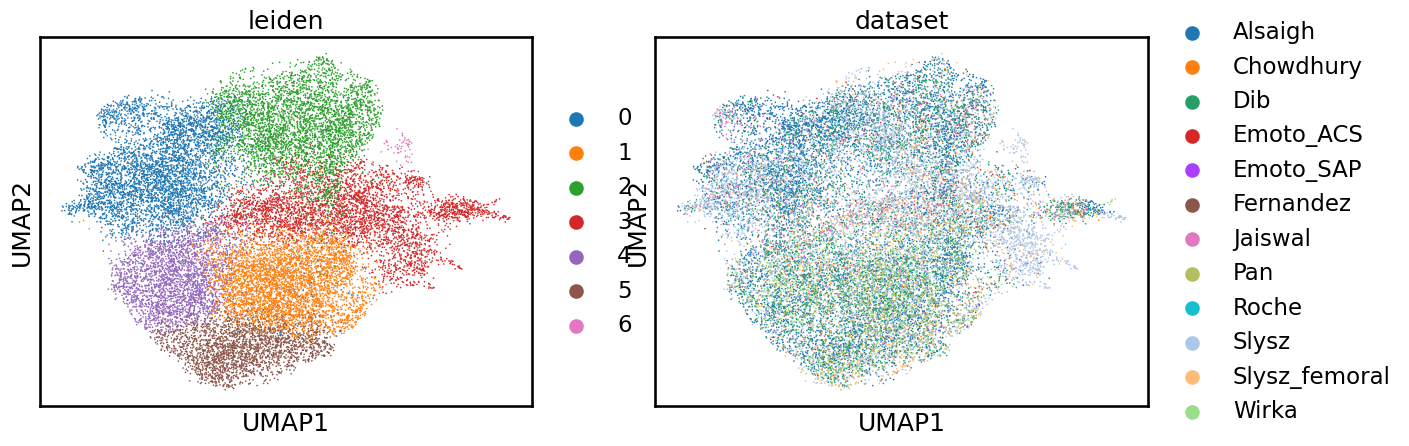

In [146]:
sc.pl.umap(adata_macros, color= ['leiden', "dataset"])

In [147]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level2_marker["Macrophages"]:
    marker_genes_in_data[celltype] = list(set(level2_marker["Macrophages"][celltype]).intersection(adata_macros.var_names))
    print(celltype, len(set(level2_marker["Macrophages"][celltype]).intersection(adata_macros.var_names))/len(level2_marker["Macrophages"][celltype]))
    print("not included: ", set(level2_marker["Macrophages"][celltype]).difference(adata_macros.var_names))

Resident 1.0
not included:  set()
Foamy 1.0
not included:  set()
Inflammatory 1.0
not included:  set()
cDC1 1.0
not included:  set()
cDC2 1.0
not included:  set()
Mature 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


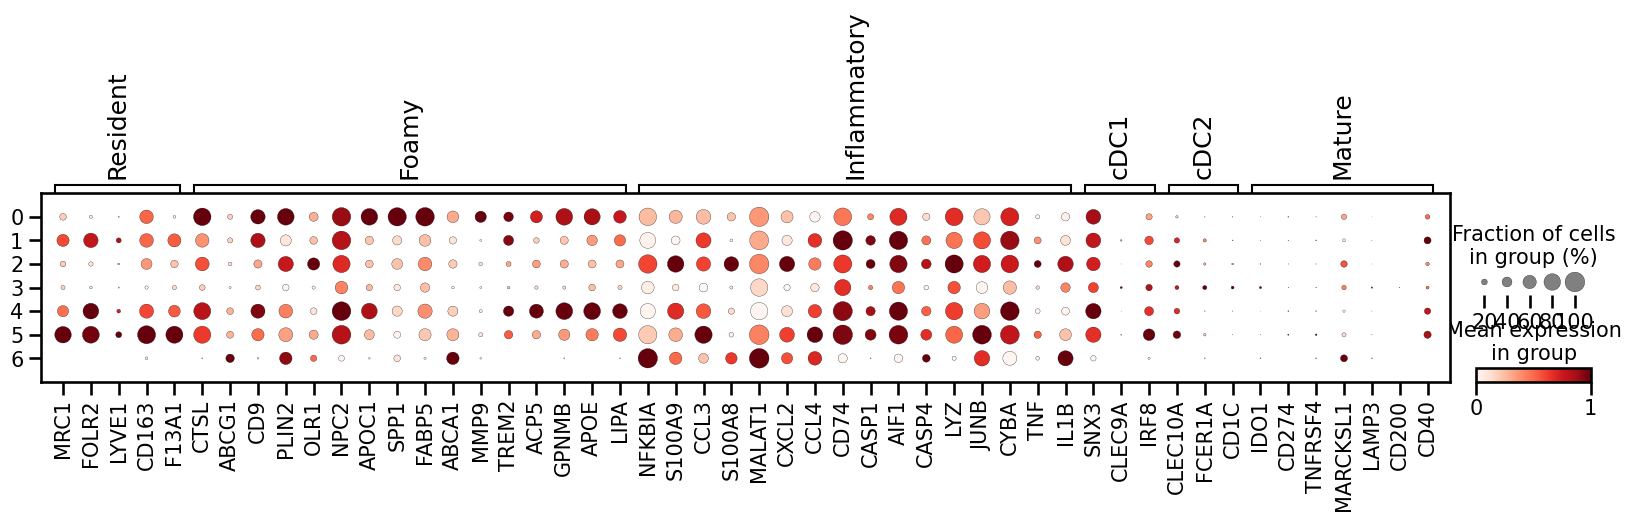

In [148]:
sc.pl.dotplot(
    adata_macros,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [155]:
#res 0.5
submacros_cell_annotation = {
    "0": "Foamy", #TREM,
    "1": "Res and Inflamm",
    "2": "Inflammatory",
    "3": "Inflammatory", #CD74
    "4": "Foamy", #TREM
    "5": "Resident", 
    "6": "Inflammatory" #all others low expressed
}

In [156]:
adata_macros.obs["cell_type_level2"] = adata_macros.obs.leiden.map(submacros_cell_annotation)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


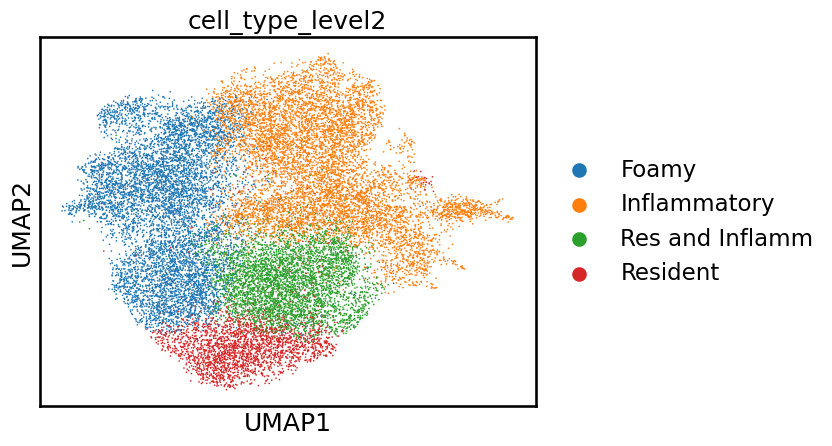

In [157]:
sc.pl.umap(adata_macros, color= ["cell_type_level2"])

In [158]:
mixed_adata = adata_macros[adata_macros.obs["cell_type_level2"]=="Res and Inflamm"]

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


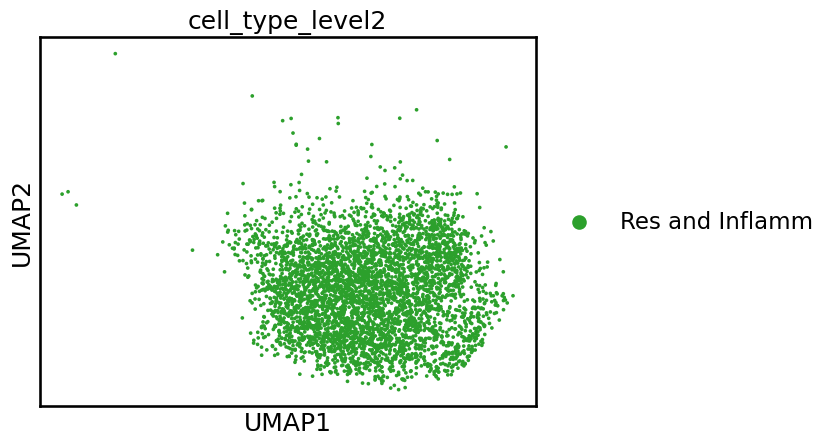

In [159]:
sc.pl.umap(mixed_adata, color= ["cell_type_level2"])

In [164]:
sc.tl.leiden(mixed_adata, resolution = 0.4,  key_added="leiden2")

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


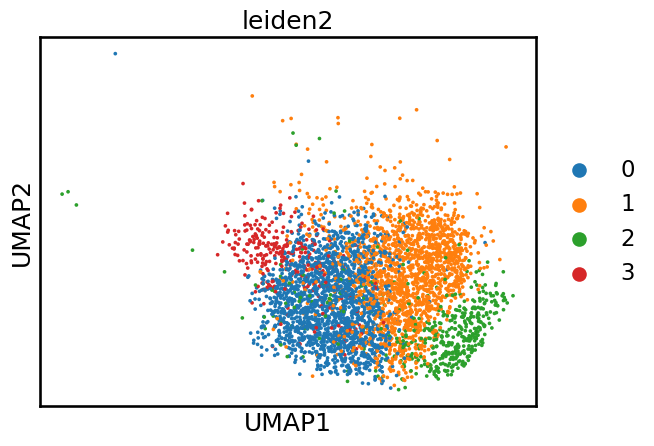

In [165]:
sc.pl.umap(mixed_adata, color= ["leiden2"])

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


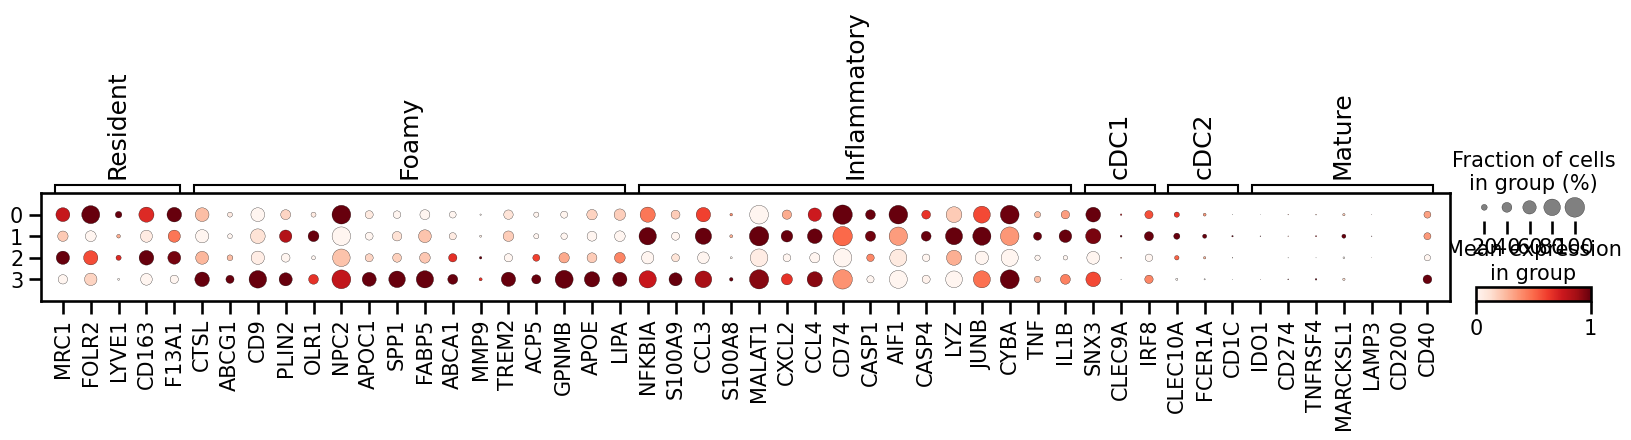

In [166]:
sc.pl.dotplot(
    mixed_adata,
    groupby="leiden2",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [167]:
subsubmacros_cell_annotation = {
    "0": "Resident",
    "1": "Inflammatory", 
    "2": "Resident",
    "3": "Foamy",
}

In [168]:
mixed_adata.obs["cell_type_level2_mixed"] = mixed_adata.obs.leiden2.map(subsubmacros_cell_annotation)

In [169]:
new_cell_types = mixed_adata.obs['cell_type_level2_mixed']

In [170]:
new_cell_types.value_counts()

Resident        2254
Inflammatory    1700
Foamy            282
Name: cell_type_level2_mixed, dtype: int64

In [171]:
adata_macros.obs['cell_type_level2'] = adata_macros.obs['cell_type_level2'].astype(str)
mixed_adata.obs['cell_type_level2_mixed'] = mixed_adata.obs['cell_type_level2_mixed'].astype(str)

In [172]:
adata_macros.obs.loc[new_cell_types.index, 'cell_type_level2'] = new_cell_types.values

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


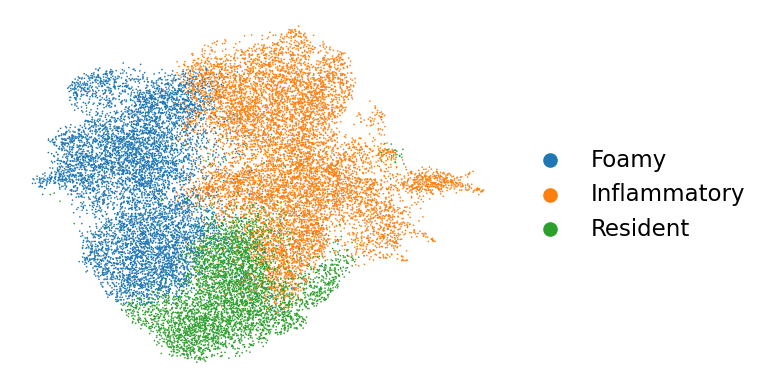

In [179]:
sc.pl.umap(adata_macros, color= ["cell_type_level2"], frameon=False, title="", save="macros-subtypes-mse-reload3.png")

In [174]:
adata_macros.write_h5ad("tmp_macros_adata_mse3-reload-annot.h5ad")

# Dentritic cells

## subsetting and normalize

In [6]:
adata_dc = adata[adata.obs["cell_type_level1_all"]=="DC"]

In [7]:
adata_dc.X = adata_dc.layers["rounded_corrected_counts"]

In [8]:
adata_dc

View of AnnData object with n_obs × n_vars = 4600 × 28488
    obs: 'dataset', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'symptoms', 'n_genes', 'n_counts', 'size_factors', 'cell_type_level1', 'cell_type_level1_all'
    var: 'original_gene_names', 'ensembl_id'
    uns: 'log1p'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'

In [9]:
#Perform a clustering for scran normalization in clusters
# warning because of uns log1p. however .X was changed
adata_pp = adata_dc.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_dc.X.T.toarray()

In [11]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/tmp/ipykernel_152140/22534

In [12]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [13]:
del adata_pp

In [14]:
adata_dc.obs['size_factors'] = size_factors

/tmp/ipykernel_152140/1212006323.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_dc.obs['size_factors'] = size_factors


In [15]:
#Normalize adata 
adata_dc.X /= adata_dc.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_dc)

In [16]:
# high variable genes selection
sc.pp.highly_variable_genes(adata_dc, n_top_genes=2000, subset=False)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please u

In [17]:
sc.pp.pca(adata_dc, svd_solver="arpack", use_highly_variable=True)

In [18]:
adata_dc.write("tmp_DC_adata_mse3-reload.h5ad")

## integrate with harmony

In [121]:
from harmony import harmonize

In [122]:
adata_dc = sc.read_h5ad("tmp_DC_adata_mse3-reload.h5ad")

In [123]:
adata_dc.obsm["Harmony"] = harmonize(adata_dc.obsm["X_pca"], adata_dc.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [124]:
sc.pp.neighbors(adata_dc, use_rep="Harmony")
sc.tl.umap(adata_dc)

In [125]:
sc.tl.leiden(adata_dc, resolution = 0.32)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


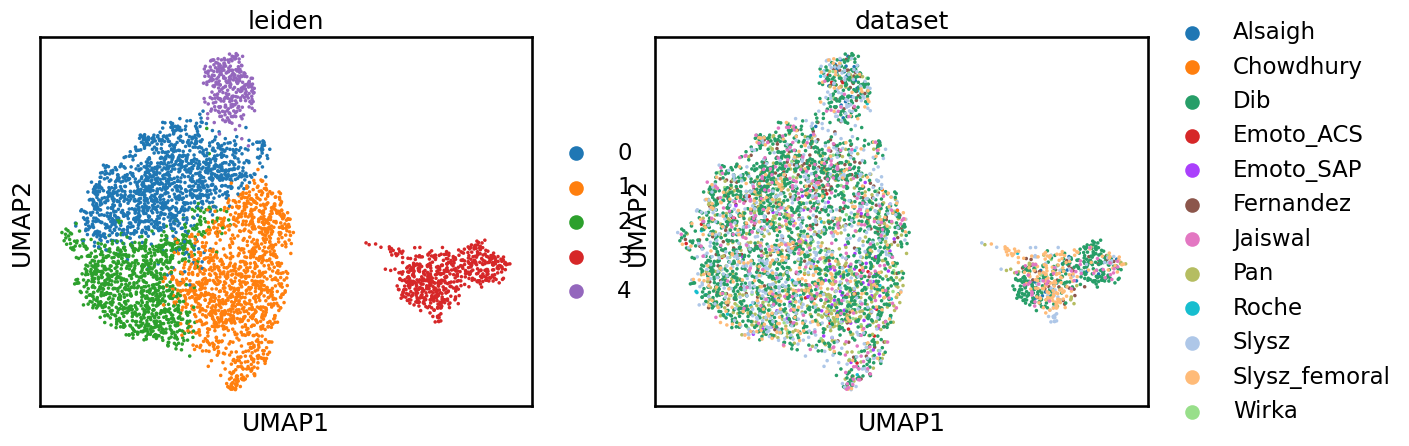

In [126]:
sc.pl.umap(adata_dc, color= ['leiden', "dataset"])

In [131]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level2_marker["DCs"]:
    marker_genes_in_data[celltype] = list(set(level2_marker["DCs"][celltype]).intersection(adata_dc.var_names))
    print(celltype, len(set(level2_marker["DCs"][celltype]).intersection(adata_dc.var_names))/len(level2_marker["DCs"][celltype]))
    print("not included: ", set(level2_marker["DCs"][celltype]).difference(adata_dc.var_names))

cDC1 1.0
not included:  set()
cDC2 1.0
not included:  set()
Mature 1.0
not included:  set()
Resident 1.0
not included:  set()
Foamy 1.0
not included:  set()
Inflammatory 1.0
not included:  set()
Monolvl1 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


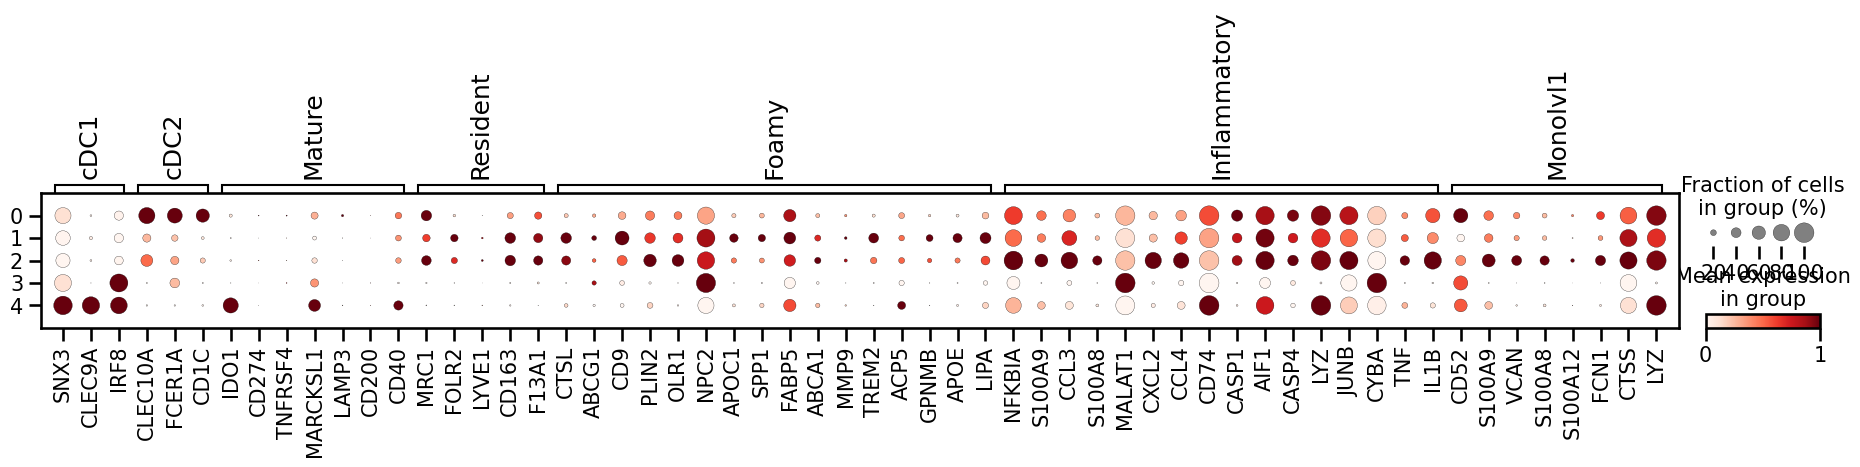

In [132]:
sc.pl.dotplot(
    adata_dc,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [133]:
dc_annotations = {
    "0": "cDC2",
    "1": "Foamy", #TREM2
    "2": "Inflammatory",
    "3": "unknown",
    "4": "cDC1"
}

In [135]:
adata_dc.obs["cell_type_level2"] = adata_dc.obs.leiden.map(dc_annotations)

In [136]:
adata_dc.write_h5ad("tmp_DC_adata_mse3-reload-annot.h5ad")

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


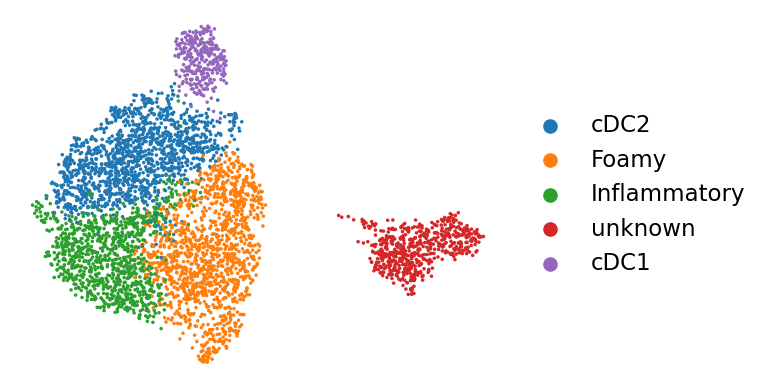

In [225]:
sc.pl.umap(adata_dc, color= ["cell_type_level2"], frameon=False, title="", save= "dc-subtypes-mse-reload3.png")

# T cells

## subsetting and normalizing

In [7]:
adata_tc = adata[adata.obs["cell_type_level1_all"]=="T cell"].copy()

In [8]:
adata_tc.X = adata_tc.layers["rounded_corrected_counts"]

In [9]:
#Perform a clustering for scran normalization in clusters
# warning because of uns log1p. however .X was changed
adata_pp = adata_tc.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_tc.X.T.toarray()

In [11]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/tmp/ipykernel_1605275/2253

In [12]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [13]:
del adata_pp

In [14]:
adata_tc.obs['size_factors'] = size_factors

In [15]:
#Normalize adata 
adata_tc.X /= adata_tc.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_tc)

In [16]:
# high variable genes selection
sc.pp.highly_variable_genes(adata_tc, n_top_genes=2000, subset=False)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please u

In [17]:
sc.pp.pca(adata_tc, svd_solver="arpack", use_highly_variable=True)

In [18]:
adata_tc.write("tmp_Tcells_adata_mse3-reload.h5ad")

## integrate with harmony

In [53]:
from harmony import harmonize

In [54]:
adata_tc = sc.read_h5ad("tmp_Tcells_adata_mse3-reload.h5ad")

In [55]:
adata_tc.obsm["Harmony"] = harmonize(adata_tc.obsm["X_pca"], adata_tc.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


In [56]:
sc.pp.neighbors(adata_tc, use_rep="Harmony")
sc.tl.umap(adata_tc)

In [57]:
sc.tl.leiden(adata_tc, resolution = 0.65)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


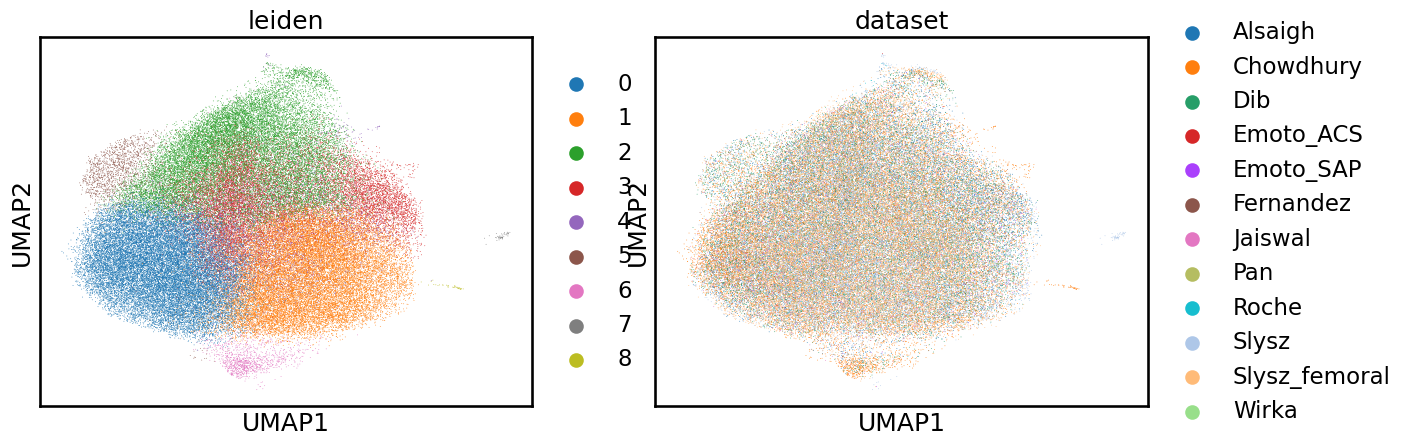

In [58]:
sc.pl.umap(adata_tc, color= ['leiden', "dataset"])

In [59]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level2_marker["Tcells"]:
    marker_genes_in_data[celltype] = list(set(level2_marker["Tcells"][celltype]).intersection(adata_tc.var_names))
    print(celltype, len(set(level2_marker["Tcells"][celltype]).intersection(adata_tc.var_names))/len(level2_marker["Tcells"][celltype]))
    print("not included: ", set(level2_marker["Tcells"][celltype]).difference(adata_tc.var_names))

CD4+ TEff 1.0
not included:  set()
CD8+ GZMK+ 1.0
not included:  set()
CD8+ GZMH+ 1.0
not included:  set()
unclear 0.8
not included:  {'HIST1HE1'}
CD4+ Treg 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


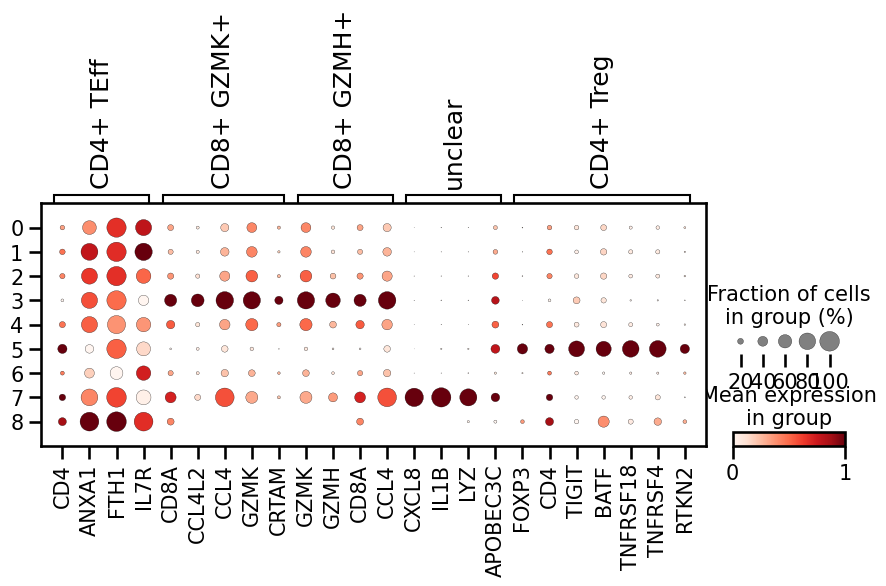

In [60]:
sc.pl.dotplot(
    adata_tc,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [49]:
slysz_tcell_annotation = {
    "0": "CD4 TEff",
    "1": "CD4 TEff",
    "2": "CD4 TEff",
    "3": "CD8",
    "4": "CD4 TEff",
    "5": "CD4 Treg", 
    "6": "CD4 TEff", #changed to unknown 
    "7": "CXCL8",
    "8": "CD4 TEff"
}

In [61]:
adata_tc.obs["cell_type_level2"] = adata_tc.obs.leiden.map(slysz_tcell_annotation)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


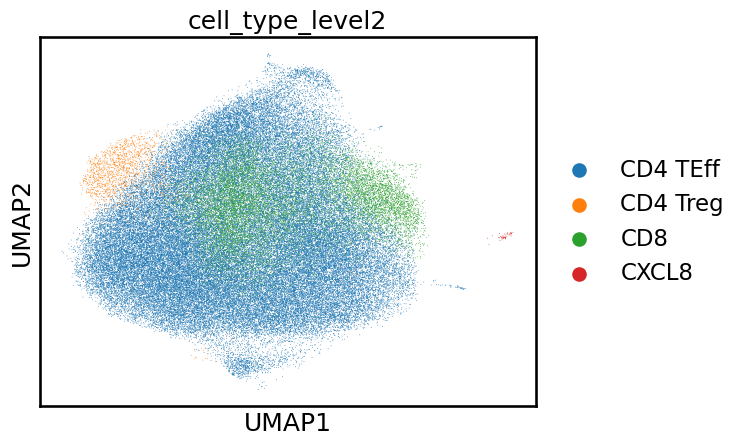

In [62]:
sc.pl.umap(adata_tc, color= ["cell_type_level2"])

In [63]:
adata_tc.obs["cell_type_level2"].value_counts()

CD4 TEff    71203
CD8         14075
CD4 Treg     1757
CXCL8          48
Name: cell_type_level2, dtype: int64

In [64]:
adata_tc.write_h5ad("tmp_Tcells_adata_mse3-reload-annot.h5ad")

In [180]:
#change cluster 6 to unknown
adata_tc = sc.read_h5ad("tmp_Tcells_adata_mse3-reload-annot.h5ad")
slysz_tcell_annotation_new = {
    "0": "CD4 TEff",
    "1": "CD4 TEff",
    "2": "CD4 TEff",
    "3": "CD8",
    "4": "CD4 TEff",
    "5": "CD4 Treg", 
    "6": "unknown", 
    "7": "CXCL8",
    "8": "CD4 TEff"
}
adata_tc.obs["cell_type_level2"] = adata_tc.obs.leiden.map(slysz_tcell_annotation_new)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


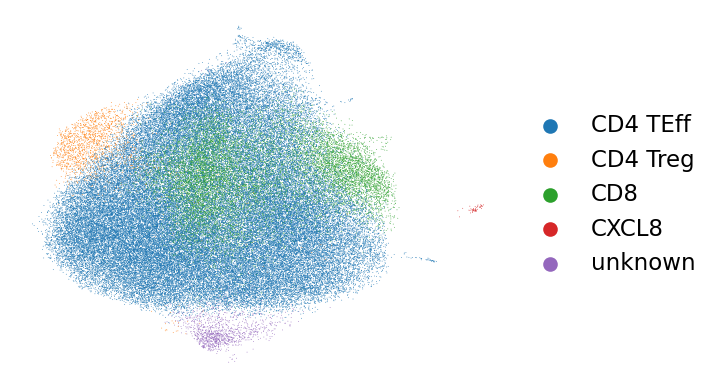

In [182]:
sc.pl.umap(adata_tc, color= ["cell_type_level2"], frameon=False, title="", save="tcells-subtypes-mse-reload3.png" )

In [226]:
adata_tc.write_h5ad("tmp_Tcells_adata_mse3-reload-annot2.h5ad")

# ECs

## subsetting and normalizing

In [43]:
adata_ec = adata[adata.obs["cell_type_level1_all"]=="EC"].copy()

In [44]:
adata_ec

AnnData object with n_obs × n_vars = 6610 × 28488
    obs: 'dataset', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'symptoms', 'n_genes', 'n_counts', 'size_factors', 'cell_type_level1', 'cell_type_level1_all'
    var: 'original_gene_names', 'ensembl_id'
    uns: 'log1p'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'

In [45]:
adata_ec.X = adata_ec.layers["rounded_corrected_counts"]

In [46]:
#Perform a clustering for scran normalization in clusters
# warning because of uns log1p. however .X was changed
adata_pp = adata_ec.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

In [47]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_ec.X.T.toarray()

In [48]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/tmp/ipykernel_152140/2253401465.py:13: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [49]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


In addition: Warning message:
In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates


In [50]:
del adata_pp

In [51]:
adata_ec.obs['size_factors'] = size_factors

In [52]:
#Normalize adata 
adata_ec.X /= adata_ec.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_ec)

In [53]:
# high variable genes selection
sc.pp.highly_variable_genes(adata_ec, n_top_genes=2000, subset=False)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please u

In [54]:
sc.pp.pca(adata_ec, svd_solver="arpack", use_highly_variable=True)

In [55]:
adata_ec.write_h5ad("tmp_ecs_adata_mse3-reload.h5ad")

## integrate with harmony

In [56]:
adata_ec = sc.read_h5ad("tmp_ecs_adata_mse3-reload.h5ad")

In [57]:
adata_ec.obsm["Harmony"] = harmonize(adata_ec.obsm["X_pca"], adata_ec.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [58]:
sc.pp.neighbors(adata_ec, use_rep="Harmony")
sc.tl.umap(adata_ec)

In [211]:
sc.tl.leiden(adata_ec, resolution = 0.2)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


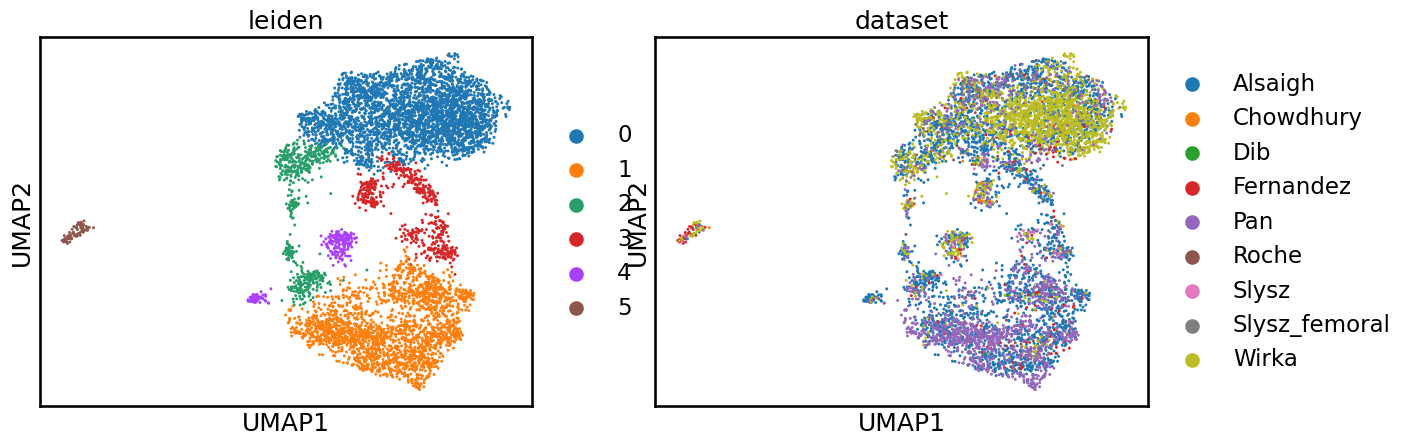

In [212]:
sc.pl.umap(adata_ec, color= ['leiden', "dataset"])

In [213]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level2_marker["ECs"]:
    marker_genes_in_data[celltype] = list(set(level2_marker["ECs"][celltype]).intersection(adata_ec.var_names))
    print(celltype, len(set(level2_marker["ECs"][celltype]).intersection(adata_ec.var_names))/len(level2_marker["ECs"][celltype]))
    print("not included: ", set(level2_marker["ECs"][celltype]).difference(adata_ec.var_names))

Initmal 1.0
not included:  set()
Proangiogenic 1.0
not included:  set()
EndoMT 1.0
not included:  set()
Lymphatic 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


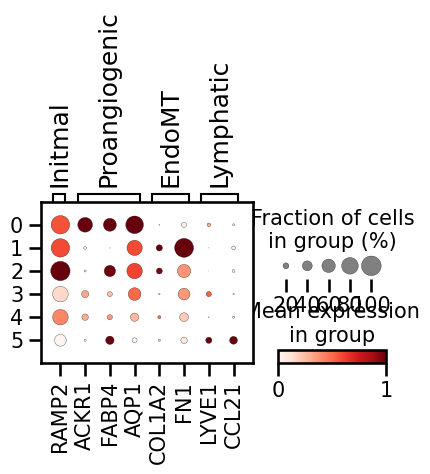

In [214]:
sc.pl.dotplot(
    adata_ec,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [216]:
ec_annotations = {
    "0" : "Proangiogenic",
    "1": "EndoMT",
    "2": "Intimal",
    "3": "unknown",
    "4": "unknown",
    "5": "Lymphatic"
}

In [217]:
adata_ec.obs["cell_type_level2"] = adata_ec.obs.leiden.map(ec_annotations)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


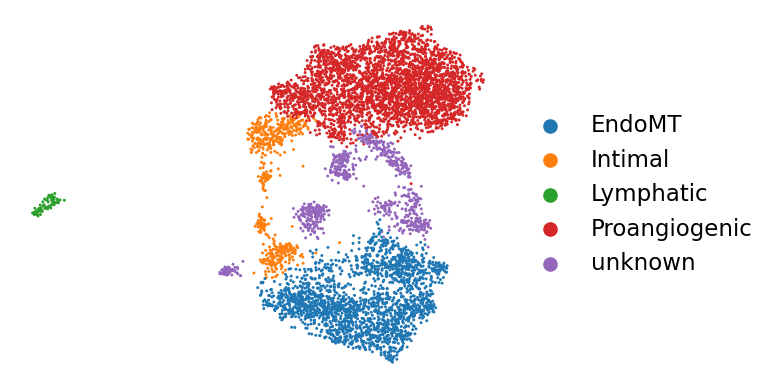

In [223]:
sc.pl.umap(adata_ec, color= ["cell_type_level2"], frameon=False, title="", save="ec-subtypes-mse-reload3.png")

In [219]:
adata_ec.write_h5ad("tmp_ecs_adata_mse3-reload-annot.h5ad")

# NK cells

## Subsetting and normalizing

In [63]:
adata_nk = adata[adata.obs["cell_type_level1_all"]=="NK"].copy()

In [65]:
adata_nk.X = adata_nk.layers["rounded_corrected_counts"]

In [66]:
#Perform a clustering for scran normalization in clusters
# warning because of uns log1p. however .X was changed
adata_pp = adata_nk.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

In [67]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_nk.X.T.toarray()

In [68]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/tmp/ipykernel_152140/2253401465.py:13: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [69]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


In addition: Warning message:
In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates


In [70]:
del adata_pp

In [71]:
adata_nk.obs['size_factors'] = size_factors

In [72]:
#Normalize adata 
adata_nk.X /= adata_nk.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_nk)

In [73]:
# high variable genes selection
sc.pp.highly_variable_genes(adata_nk, n_top_genes=2000, subset=False)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please u

In [77]:
sc.pp.pca(adata_nk, svd_solver="arpack", use_highly_variable=True)

In [78]:
adata_nk.write_h5ad("tmp_nk_adata_mse3-reload.h5ad")

## integrate with harmony

In [79]:
adata_nk = sc.read_h5ad("tmp_nk_adata_mse3-reload.h5ad")

In [80]:
adata_nk.obsm["Harmony"] = harmonize(adata_nk.obsm["X_pca"], adata_nk.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [81]:
sc.pp.neighbors(adata_nk, use_rep="Harmony")
sc.tl.umap(adata_nk)

In [104]:
sc.tl.leiden(adata_nk, resolution = 0.4)

In [105]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level2_marker["NK"]:
    marker_genes_in_data[celltype] = list(set(level2_marker["NK"][celltype]).intersection(adata_nk.var_names))
    print(celltype, len(set(level2_marker["NK"][celltype]).intersection(adata_nk.var_names))/len(level2_marker["NK"][celltype]))
    print("not included: ", set(level2_marker["NK"][celltype]).difference(adata_nk.var_names))

nk 1.0
not included:  set()
CD4+ TEff 1.0
not included:  set()
CD8+ GZMK+ 1.0
not included:  set()
CD8+ GZMH+ 1.0
not included:  set()
CXCL8 0.8
not included:  {'HIST1HE1'}
CD4+ Treg 1.0
not included:  set()
Tcell 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


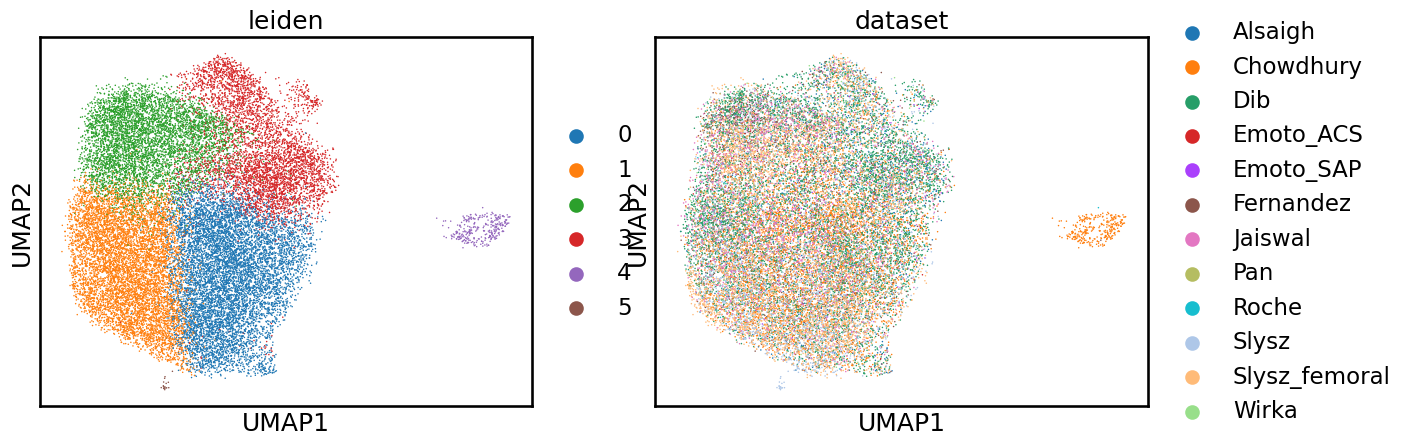

In [106]:
sc.pl.umap(adata_nk, color= ['leiden', 'dataset'])

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


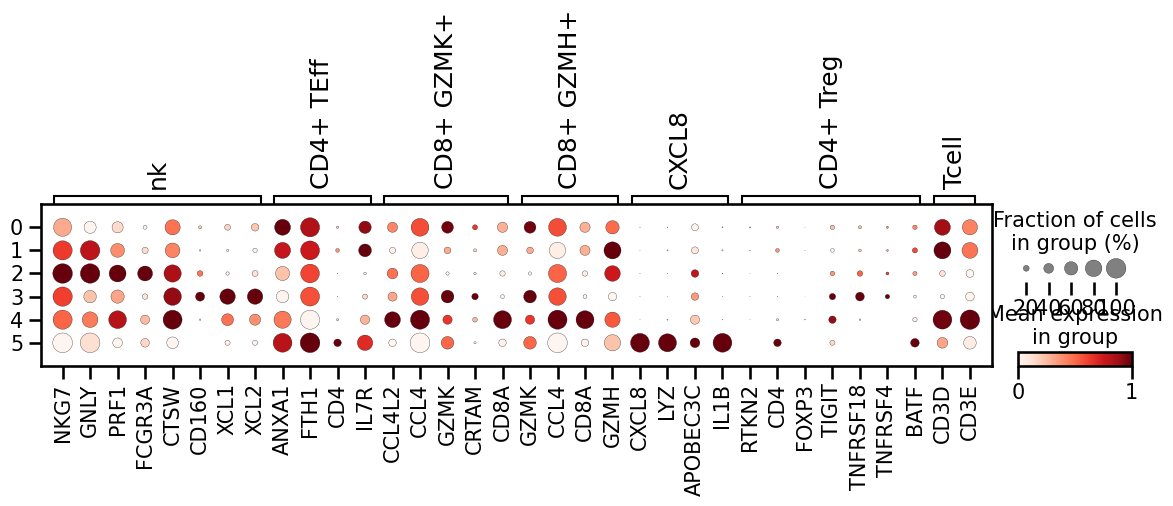

In [107]:
sc.pl.dotplot(
    adata_nk,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [110]:
nk_tcell_annotation = {
    "0": "CD4 TEff",
    "1": "CD4 TEff", # very hard. NKG7 and GNLY is also active. But CD3D should mean its t cells
    "2": "NK",
    "3": "NK",
    "4": "CD8",
    "5": "CXCL8"
}

In [111]:
adata_nk.obs["cell_type_level2"] = adata_nk.obs.leiden.map(nk_tcell_annotation)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


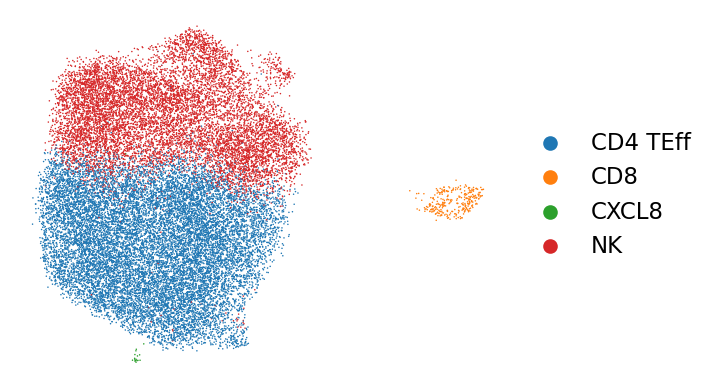

In [222]:
sc.pl.umap(adata_nk, color= ["cell_type_level2"], frameon = False, title="", save="nk-subtypes-mse-reload3.png")

In [113]:
adata_nk.write_h5ad("tmp_nk_adata_mse3-reload-annot.h5ad")

# Assign cell type labels to big adata

In [3]:
adata_atlas = sc.read_h5ad("Altas_level1-noprototypes-mse-3-reload.h5ad")
adata_atlas.obs_names = adata_atlas.obs_names.str[:-2]

In [19]:
adata = sc.read_h5ad("Altas_level1-noprototypes-allgenes-names-mse3-reload.h5ad")

In [20]:
adata_nk = sc.read_h5ad("tmp_nk_adata_mse3-reload-annot.h5ad")
adata_tc = sc.read_h5ad("tmp_Tcells_adata_mse3-reload-annot2.h5ad")
adata_macros = sc.read_h5ad("tmp_macros_adata_mse3-reload-annot.h5ad")
adata_dc = sc.read_h5ad("tmp_DC_adata_mse3-reload-annot.h5ad")
adata_ec = sc.read_h5ad("tmp_ecs_adata_mse3-reload-annot.h5ad")

In [21]:
adata_list = [adata_nk, adata_tc, adata_macros, adata_dc, adata_ec]

In [22]:
adata_concat = anndata.concat(adata_list, join='outer', fill_value=0.0)

In [23]:
# Extract barcodes and cell_type_level2 values
barcodes = adata_concat.obs_names
cell_types_level2 = adata_concat.obs["cell_type_level2"]

# Create the mapping
mapping = dict(zip(barcodes, cell_types_level2))

In [24]:
# adata is loaded in the beginning of this notebook and is all genes

In [25]:
# Initialize "cell_type_level2" in adata with "cell_type_level1_all"
# It's assumed that "cell_type_level1_all" already exists in adata.obs
adata.obs["cell_type_level2"] = adata.obs["cell_type_level1_all"].astype(str)

In [26]:
# Update "cell_type_level2" in adata for matching barcodes
for barcode in adata.obs_names:
    if barcode in mapping:
        adata.obs.at[barcode, "cell_type_level2"] = mapping[barcode]

In [28]:
adata.write("Altas_level1-noprototypes-allgenes-names-mse3-reload-level2.h5ad") # used for reference training in 6_integration_level2.ipynb

# Alternative EC subtypes for deconvolution

## subsetting and normalizing

In [2]:
adata = sc.read_h5ad("Altas_level2-noprototypes-allgenes-names-mse3-reload.h5ad") # output of adjusted level 2 reference training in 6_integration_level2.ipynb

In [4]:
adata_ec = adata[adata.obs["cell_type_level1"]=="EC"].copy()

In [5]:
adata_ec

AnnData object with n_obs × n_vars = 6589 × 28488
    obs: 'dataset', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'symptoms', 'n_genes', 'n_counts', 'size_factors', 'cell_type_level1', 'cell_type_level2'
    var: 'original_gene_names', 'ensembl_id'
    uns: 'log1p'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'

In [9]:
ec_subtypes = {
    "Arterial ECs": ["GJ4", "GJ5", "GATA2", "MECOM", "GJA4", "GJA5"],
    "Venous ECs": ["ACKR1", "NR2F2"],
    "lymphatic" : ["LYVE1", "CCL21"],
    "intimal" : ["RAMP2"],
    "proangiogenic" : ["ACKR1", "AQP1", "FABP4"],
    "endomt" : ["COL1A2", "FN1"]
}

In [10]:
level2_marker = {
    "ECs": ec_subtypes
}

In [8]:
adata_ec.X = adata_ec.layers["rounded_corrected_counts"]

In [9]:
#Perform a clustering for scran normalization in clusters
# warning because of uns log1p. however .X was changed
adata_pp = adata_ec.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_ec.X.T.toarray()

In [11]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/tmp/ipykernel_958671/22534

In [12]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [13]:
del adata_pp

In [14]:
adata_ec.obs['size_factors'] = size_factors

In [15]:
#Normalize adata 
adata_ec.X /= adata_ec.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_ec)

In [16]:
# high variable genes selection
sc.pp.highly_variable_genes(adata_ec, n_top_genes=2000, subset=False)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [17]:
sc.pp.pca(adata_ec, svd_solver="arpack", use_highly_variable=True)

In [18]:
adata_ec.write_h5ad("tmp_ecs_adata_mse3-reload-level2.h5ad")

## integrate with harmony

In [21]:
from harmony import harmonize

In [22]:
adata_ec.obsm["Harmony"] = harmonize(adata_ec.obsm["X_pca"], adata_ec.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [23]:
sc.pp.neighbors(adata_ec, use_rep="Harmony")
sc.tl.umap(adata_ec)

In [32]:
sc.tl.leiden(adata_ec, resolution = 0.1)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

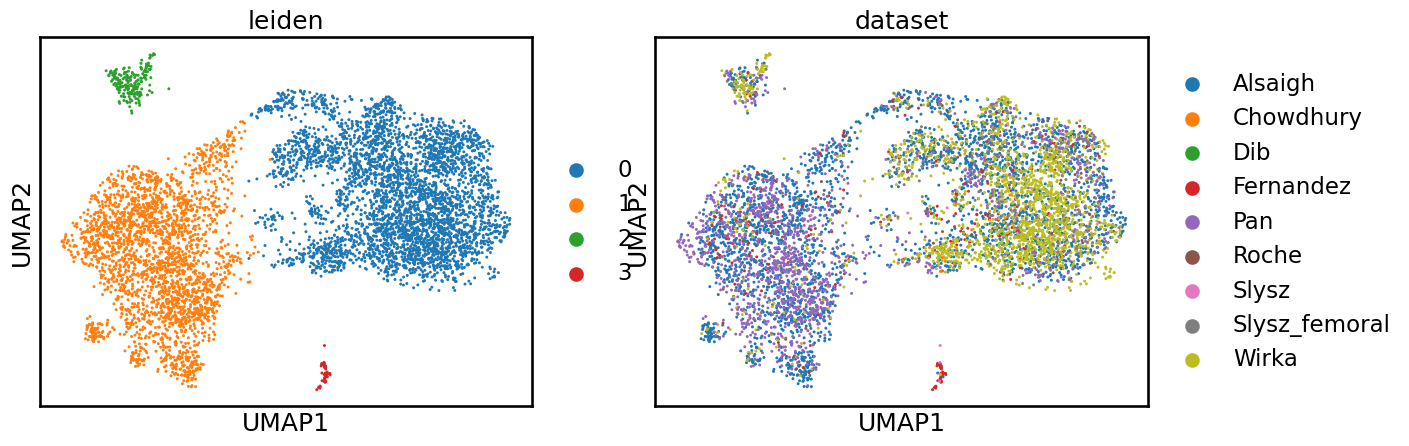

In [36]:
sc.pl.umap(adata_ec, color= ['leiden', "dataset"])

In [11]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level2_marker["ECs"]:
    marker_genes_in_data[celltype] = list(set(level2_marker["ECs"][celltype]).intersection(adata_ec.var_names))
    print(celltype, len(set(level2_marker["ECs"][celltype]).intersection(adata_ec.var_names))/len(level2_marker["ECs"][celltype]))
    print("not included: ", set(level2_marker["ECs"][celltype]).difference(adata_ec.var_names))

Arterial ECs 0.6666666666666666
not included:  {'GJ5', 'GJ4'}
Venous ECs 1.0
not included:  set()
lymphatic 1.0
not included:  set()
intimal 1.0
not included:  set()
proangiogenic 1.0
not included:  set()
endomt 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

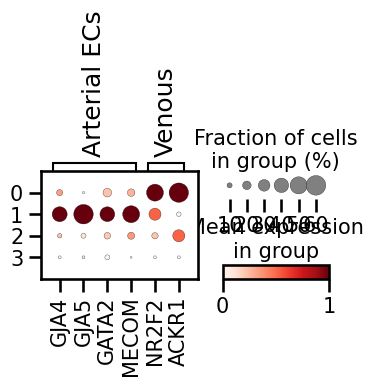

In [38]:
sc.pl.dotplot(
    adata_ec,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [39]:
ec_annotations = {
    "0" : "Arterial ECs", # wrongly assigned here. swapped with venous later in 6_integration_level2.ipynb
    "1": "Venous ECs", # wrongly assigned here. swapped with arterial later in 6_integration_level2.ipynb
    "2": "ECs",
    "3": "ECs",
}

In [40]:
adata_ec.obs["cell_type_level2"] = adata_ec.obs.leiden.map(ec_annotations)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


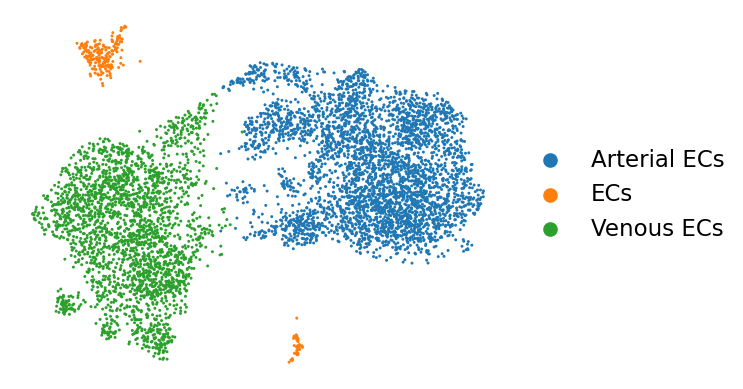

In [41]:
sc.pl.umap(adata_ec, color= ["cell_type_level2"], frameon=False, title="")

In [42]:
adata_ec.write("tmp_ecs_adata_mse3-reload-level2-annot.h5ad")

# Alternative SMC subtypes for deconvolution

In [ ]:
# to be included eventually